
# Tracking automatique de tempêtes dans les réanalyses ERA5

Calepin à utiliser pour le calcul de trajectoires de tempêtes remarquables à partir de réanalyses ERA5 de Pmer (fichier msl.nc à récupérer sur Copernicus et à mettre dans le dossier "data/storm") :
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form

Les fichiers texte des trajectoires des tempêtes sont stockés dans le répertoire "txt".

In [1]:
import os

import xarray as xr
import netCDF4

import numpy as np

from cartopy import config
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

import pandas as pd

from tqdm import tqdm

from scipy.ndimage import maximum_filter, minimum_filter

from shapely.geometry import Point

In [2]:
def plot_maxmin_points(data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(data.longitude[mxx[i]].values, data.latitude[mxy[i]].values, symbol, color=color, size=12,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(data.longitude[mxx[i]].values, data.latitude[mxy[i]].values,
                '\n' + str(int(data[mxy[i], mxx[i]])),
                color=color, size=10, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)

def print_maxmin_points(data, extrema, nsize):
    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='nearest')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='nearest')
    else:
        raise ValueError('Value for hilo must be either max or min')

    mxy, mxx = np.where(data_ext == data)

    for i in range(len(mxy)):
        # Print date lon lat and pressure of the minimum
        print(date, data.longitude[mxx[i]].values, data.latitude[mxy[i]].values, int(data[mxy[i], mxx[i]]))

def lonflip(da):
    lon_name = 'longitude'
    da['_longitude_adjusted'] = xr.where(
        da[lon_name] > 180,
        da[lon_name] - 360,
        da[lon_name])
    da = (
        da
        .swap_dims({lon_name: '_longitude_adjusted'})
        .sel(**{'_longitude_adjusted': sorted(da._longitude_adjusted)})
        .drop(lon_name))
    da = da.rename({'_longitude_adjusted': lon_name})
    return da

In [3]:
projection=ccrs.PlateCarree()

def plot_background(ax):
    ax.coastlines()
    ax.gridlines()
    ax.set_xticks(np.linspace(-180, 180, 19), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(-90, 90, 19), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    return(ax)        

def make_animation(gif_filepath):
    from PIL import Image
    import os
    from IPython.display import Image as IPImage
    from IPython.display import display
    import time
    
    image_folder = './anim/'+storm+'/' # répertoire contenant les fichiers PNG
    output_file = gif_filepath # nom du fichier de sortie
    animation_speed = 0.9 # vitesse de l'animation en secondes
    
    # Liste tous les fichiers PNG dans le répertoire image_folder
    files = sorted(os.listdir(image_folder))
    image_files = [f for f in files if f.endswith('.png')]
    
    # Ouvre chaque fichier PNG et ajoute l'image à une liste
    images = []
    for filename in image_files:
        img = Image.open(os.path.join(image_folder, filename))
        images.append(img)
    
    # Crée l'animation GIF
    images[0].save(output_file, save_all=True, append_images=images[1:], duration=int(animation_speed*1000), loop=0)
    # Affiche l'animation GIF dans Jupyter
    with open(output_file,'rb') as f:
        display(IPImage(data=f.read(), format='png'))
    # Efface les fichiers PNG
    for filename in image_files:
        os.remove(image_folder+filename)

<div class="alert alert-danger">
<p><b>Réaliser le tracking automatique pour l'ensemble des tempêtes ci-dessous afin de créer les fichiers texte de toutes les trajectoires.</b></p>
</div>

In [4]:
def print_menu():
    print ('1 -- Nov1982' )
    print ('2 -- Oct1987' )
    print ('3 -- Herta' )
    print ('4 -- Viviane' )
    print ('5 -- Lothar' )
    print ('6 -- Martin' )
    print ('7 -- Klaus' )
    print ('8 -- Xynthia' )
    print ('9 -- Joachim' )
    print ('10 -- Zeus' )
    print ('11 -- Ophelia' )
    print ('12 -- Eleanor' )
    print ('13 -- Alex' )
    print ('14 -- Ciaran' )
    print ('15 -- Braer' )
    
print_menu()

option = int(input('Enter number of the desired storm : ')) 
if option == 1:
    storm='Nov1982'
elif option == 2:
    storm='Oct1987'
elif option == 3:
    storm='Herta'
elif option == 4:
    storm='Viviane'
elif option == 5:
    storm='Lothar'
elif option == 6:
    storm='Martin'
elif option == 7:
    storm='Klaus'
elif option == 8:
    storm='Xynthia'
elif option == 9:
    storm='Joachim'
elif option == 10:
    storm='Zeus'
elif option == 11:
    storm='Ophelia'
elif option == 12:
    storm='Eleanor'
elif option == 13:
    storm='Alex'
elif option == 14:
    storm='Ciaran'
elif option == 15:
    storm='Braer'
else:
    print('Invalid option. Please enter a number between 1 and 14.')
    
if not os.path.exists('./anim/'+storm):
    os.mkdir('./anim/'+storm)

if not os.path.exists('./figs/'+storm):
    os.mkdir('./figs/'+storm)
    
dir_anim ='./anim/'+storm+'/'
dir_data ='./data/'+storm+'/'

if not os.path.exists(dir_data+"msl.nc"):
    print('Error : file msl.nc is not present in the folder data/'+storm)
else:
    print('All good : file msl.nc is present in the folder data/'+storm)

1 -- Nov1982
2 -- Oct1987
3 -- Herta
4 -- Viviane
5 -- Lothar
6 -- Martin
7 -- Klaus
8 -- Xynthia
9 -- Joachim
10 -- Zeus
11 -- Ophelia
12 -- Eleanor
13 -- Alex
14 -- Braer
Enter number of the desired storm : 7
All good : file msl.nc is present in the folder data/Klaus


In [5]:
if storm=='Nov1982':
    date1='1982-11-06T03'
    date2='1982-11-08T12'                                 
if storm=='Oct1987':
    date1='1987-10-15T09'
    date2='1987-10-16T23'                                 
if storm=='Herta':
    date1='1990-02-02T09'
    date2='1990-02-04T05'                                 
if storm=='Viviane':
    date1='1990-02-26T00'
    date2='1990-02-28T00'                                 
if storm=='Lothar':
    date1='1999-12-25T00'
    date2='1999-12-26T15'                                 
if storm=='Martin':
    date1='1999-12-26T12'
    date2='1999-12-28T04'                                 
if storm=='Klaus':
    date1='2009-01-23T06'
    date2='2009-01-24T15'                                 
if storm=='Xynthia':
    date1='2010-02-26T21'
    date2='2010-02-28T21'                                 
if storm=='Joachim':
    date1='2011-12-15T03'
    date2='2011-12-17T23'
if storm=='Zeus':
    date1='2017-03-06T04'
    date2='2017-03-17T23' 
if storm=='Ophelia':
    date1='2017-10-14T00'
    date2='2017-10-17T21'                                
if storm=='Eleanor':
    date1='2018-01-02T20'
    date2='2018-01-04T10'   
if storm=='Alex':
    date1='2020-10-01T14'
    date2='2020-10-03T06'
if storm=='Ciaran':
    date1='2023-10-30T00'
    date2='2023-11-03T23'   
if storm=='Braer':
    date1='1993-01-08T22'
    date2='1993-01-13T23'

In [6]:
latS=30
latN=70
lonW=-60
lonE=30

if storm=='Braer':
    latS=40
    latN=80
    lonW=-80
    lonE=20

f1    = xr.open_dataset(dir_data+"msl.nc").sel(time=slice(date1,date2)).sel(latitude=slice(latN,latS))
print(f1)

mslp0 = f1['msl']/100
lat  = mslp0.latitude.values
time  = mslp0.time.values

mslp = lonflip(mslp0)
mslp=mslp.sel(longitude=slice(lonW,lonE))

lon  = mslp.longitude.values

print(mslp)

<xarray.Dataset>
Dimensions:    (longitude: 601, latitude: 161, time: 34)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... 49.5 49.75 50.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 2009-01-23T06:00:00 ... 2009-01-24T15:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-14 06:45:31 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...
<xarray.DataArray 'msl' (time: 34, latitude: 161, longitude: 361)>
array([[[ 988.64764,  988.46216,  988.28516, ..., 1002.5237 ,
         1002.63666, 1002.75464],
        [ 988.31384,  988.15875,  988.0036 , ..., 1002.9249 ,
         1003.0193 , 1003.1373 ],
        [ 987.93115,  987.77435,  987.61755, ..., 1003.3986 ,
         1003.52   , 1003.6397 ],
        ...,
        [1023.36224, 1023.3336 , 1023.2914 , ..., 1013.31134,
         1013.4293 , 1013.26416],
        [1023.1886 , 1023.15

In [7]:
%%capture cap --no-stderr
for i in range(len(time)):
    date=str(time[i])[0:13]   
    print_maxmin_points(mslp[i,:,:], 'min', 25)

In [8]:
file_era = './txt/era5_tracking.txt'
with open(file_era, 'w') as f:
    f.write(cap.stdout)
f.close()

In [9]:
buffer=3
if storm=='Martin':
    buffer=4
if storm=='Braer':
    buffer=4
    
def tracking(file): 
    df = pd.read_csv(file,sep=" ",header=None)
    liste_date =  np.unique(df[0].values)
    # We will track lows that are present at initial time
    ds = df.to_xarray()
    original_position = ds.sel(index= ds[0] == liste_date[0])
    # Build individual tracking for each detected low
    traj = []
    for ind in original_position.index.values: # Boucle sur les depressions à t=0
        position = Point(original_position.sel(index=ind)[1],original_position.sel(index=ind)[2])
        dep_traj = []
        dep_traj.append((
            original_position.sel(index=ind)[1].values,
            original_position.sel(index=ind)[2].values,
            original_position.sel(index=ind)[0].values,
            original_position.sel(index=ind)[3].values, 
            ))
        for date in liste_date[1:]: # Loop for all timesteps
            temp = ds.sel(index= ds[0] == date)
            l_area = []
            for other_idx in temp.index.values: 
                oth_pos = Point(temp.sel(index=other_idx)[1],temp.sel(index=other_idx)[2])
                l_area.append(position.buffer(buffer).intersection(oth_pos.buffer(buffer)).area) 
                # Finding intersection between two circles of 1°. 
            if np.max(l_area)>0.001: # Compare areas
                elt = np.argmax(l_area)
                n_position=Point(temp.isel(index=elt)[1],temp.isel(index=elt)[2])
                dep_traj.append([
                    temp.isel(index=elt)[1].values,
                    temp.isel(index=elt)[2].values,
                    temp.isel(index=elt)[0].values,
                    temp.isel(index=elt)[3].values] )
                position = n_position
            else: 
                break
        traj.append(dep_traj)
    return traj

In [10]:
tracking_era = tracking(file_era)
print("Number of tracked lows from "+date1+": ", len(tracking_era))

Number of tracked lows from 2009-01-23T06:  8


In [11]:
def get_list(low): 
    list_lat = []
    list_lon = []
    list_time = []
    list_pres = []
    for i in range(len(low)):
        list_lon.append(low[i][0])
        list_lat.append(low[i][1])
        list_time.append(low[i][2])
        list_pres.append(low[i][3])
    return list_lon, list_lat, list_time, list_pres

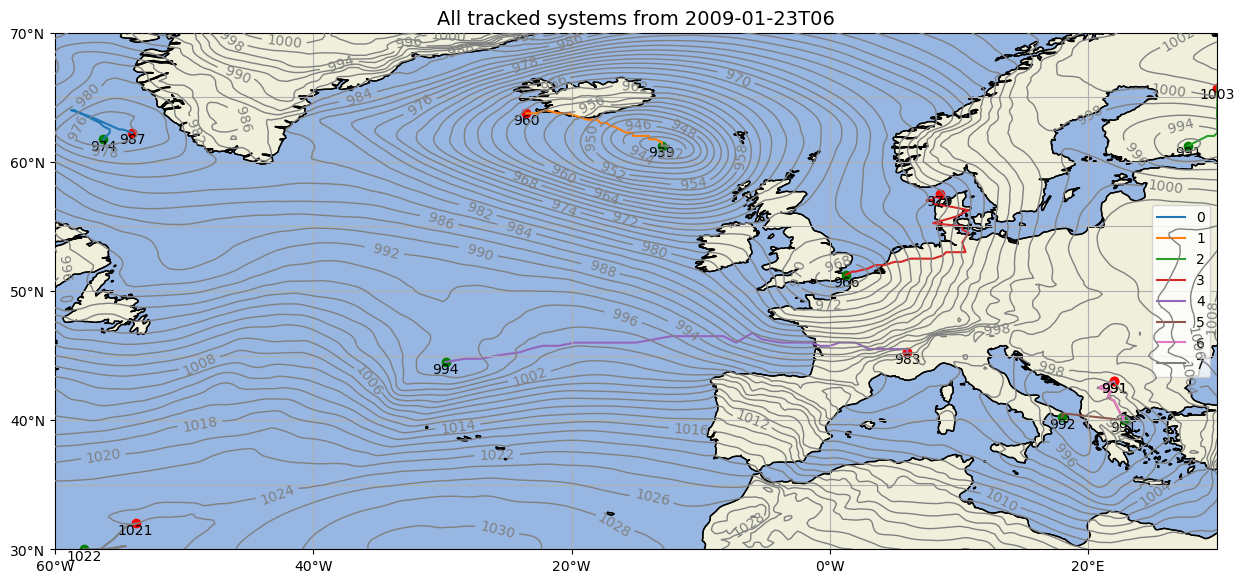

In [12]:
mslp_levels = np.arange(900,1072,2)
projection=ccrs.PlateCarree()
bounds = [(lonW, lonE, latS, latN)]

fig = plt.figure(figsize=(15., 10.))
ax = fig.add_subplot(111, projection=projection)
ax.set_title('All tracked systems from '+date1,loc='center',fontsize=14)
plot_background(ax)
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
c = ax.contour(lon, lat, mslp[0,:,:], levels=mslp_levels, colors="grey", linewidths=1, transform=ccrs.PlateCarree(), zorder=10)
ax.clabel(c,fmt='%4.1i',fontsize=10)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())

for ind in range(len(tracking_era)):
    liste_lon, liste_lat, liste_time, liste_pres = get_list(tracking_era[ind])
    ax.plot(liste_lon,liste_lat, label=ind, transform=ccrs.PlateCarree())
    ax.scatter(liste_lon[0],liste_lat[0], color='green', transform=ccrs.PlateCarree())
    ax.scatter(liste_lon[-1],liste_lat[-1], color='red', transform=ccrs.PlateCarree())
    ax.text(liste_lon[0], liste_lat[0], liste_pres[0],verticalalignment='top', horizontalalignment='center',
            transform=ccrs.PlateCarree())
    ax.text(liste_lon[-1], liste_lat[-1], liste_pres[-1],verticalalignment='top', horizontalalignment='center',
            transform=ccrs.PlateCarree())
plt.legend(loc='right')
plt.show()

figname='./figs/'+storm+'/tracks'
fig.savefig(figname+'.png',bbox_inches='tight')

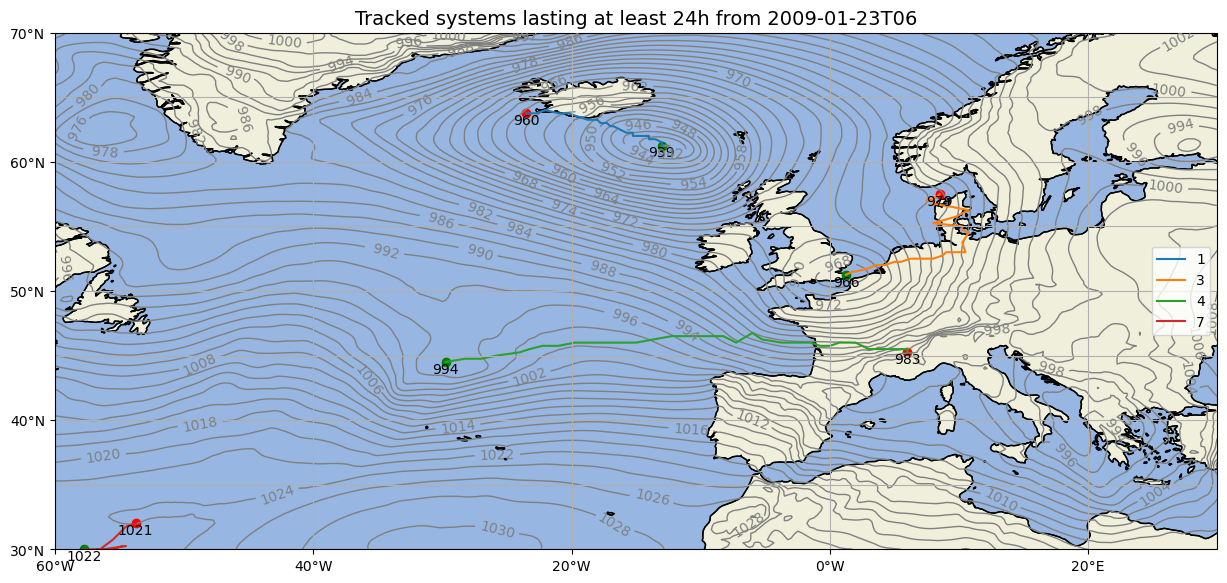

In [13]:
fig = plt.figure(figsize=(15., 10.))
ax = fig.add_subplot(111, projection=projection)
ax.set_title('Tracked systems lasting at least 24h from '+date1,loc='center',fontsize=14)
plot_background(ax)
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
c = ax.contour(lon, lat, mslp[0,:,:], levels=mslp_levels, colors="grey", linewidths=1, transform=ccrs.PlateCarree())
ax.clabel(c,fmt='%4.1i',fontsize=10)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())

for ind in range(len(tracking_era)):
    liste_lon, liste_lat, liste_time, liste_pres = get_list(tracking_era[ind])
    if len(liste_lon) >24: 
        ax.plot(liste_lon,liste_lat, label=ind, transform=ccrs.PlateCarree())
        ax.scatter(liste_lon[0],liste_lat[0], color='green', transform=ccrs.PlateCarree())
        ax.scatter(liste_lon[-1],liste_lat[-1], color='red', transform=ccrs.PlateCarree())
        ax.text(liste_lon[0], liste_lat[0], liste_pres[0],verticalalignment='top', horizontalalignment='center',
                transform=ccrs.PlateCarree())
        ax.text(liste_lon[-1], liste_lat[-1], liste_pres[-1],verticalalignment='top', horizontalalignment='center',
                transform=ccrs.PlateCarree())
plt.legend(loc='right')
plt.show()

figname='./figs/'+storm+'/tracks24h'
fig.savefig(figname+'.png',bbox_inches='tight')

In [14]:
ind_era = int(input("Enter index of storm "+storm+" : "))
print('Number of points for the desired low : '+str(len(tracking_era[ind_era])))
print(tracking_era[ind_era])

Enter index of storm Klaus : 4
Number of points for the desired low : 34
[(array(-29.75), array(44.5), array('2009-01-23T06', dtype=object), array(994, dtype=int64)), [array(-28.25), array(44.75), array('2009-01-23T07', dtype=object), array(993, dtype=int64)], [array(-27.), array(44.75), array('2009-01-23T08', dtype=object), array(991, dtype=int64)], [array(-25.75), array(45.), array('2009-01-23T09', dtype=object), array(990, dtype=int64)], [array(-24.), array(45.25), array('2009-01-23T10', dtype=object), array(984, dtype=int64)], [array(-23.25), array(45.5), array('2009-01-23T11', dtype=object), array(982, dtype=int64)], [array(-22.25), array(45.75), array('2009-01-23T12', dtype=object), array(980, dtype=int64)], [array(-21.), array(45.75), array('2009-01-23T13', dtype=object), array(977, dtype=int64)], [array(-19.75), array(46.), array('2009-01-23T14', dtype=object), array(975, dtype=int64)], [array(-18.75), array(46.), array('2009-01-23T15', dtype=object), array(973, dtype=int64)], 

In [15]:
liste_lon, liste_lat, liste_time, liste_pres = get_list(tracking_era[ind_era])
list_time = [str(x) for x in liste_time]

In [16]:
file_storm = './txt/'+storm+'.txt'
file=open(file_storm, "w+")
for i in range(len(tracking_era[ind_era])):
    file.write(str(liste_time[i]))
    file.write(' ')
    file.write(str(liste_lon[i]))
    file.write(' ')
    file.write(str(liste_lat[i]))
    file.write(' ')
    file.write(str(liste_pres[i]))
    file.write("\n")
file.close()

In [17]:
for i in tqdm(range(len(tracking_era[ind_era]))):
    #print(str(tracking_era[ind_era][i][2])[0:13])
    fig = plt.figure(figsize=(15., 10.))

    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.set_title('Storm '+storm+' - MSLP and tracking : '+list_time[0]+' to ' +list_time[-1],loc='left',fontsize=14)
    ax.set_title(str(time[i])[0:13],loc='right',fontsize=14)
    plot_background(ax)
    ax.set_extent(*bounds, crs=ccrs.PlateCarree())
    
    # MSLP in contours and min max
    c1 = ax.contour(lon, lat, mslp[i,:,:], levels=mslp_levels, colors="black", linewidths=1, transform=ccrs.PlateCarree())
    ax.clabel(c1,fmt='%4.1i',fontsize=10)
    plot_maxmin_points(mslp[i,:,:], 'min', 25,
                       symbol='L', color='b', transform=ccrs.PlateCarree()) 
    # Track from lat/lon in txt file
    ax.scatter(tracking_era[ind_era][i][0],tracking_era[ind_era][i][1], c='green', transform=ccrs.PlateCarree())
    ax.plot(liste_lon[0:i+1],liste_lat[0:i+1], c='red', marker='+', transform=ccrs.PlateCarree())
    
    figname='./anim/'+storm+'/MSL_tracking_'+list_time[i]
    fig.savefig(figname+'.png',bbox_inches='tight')
    plt.close()

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:32<00:00,  1.05it/s]


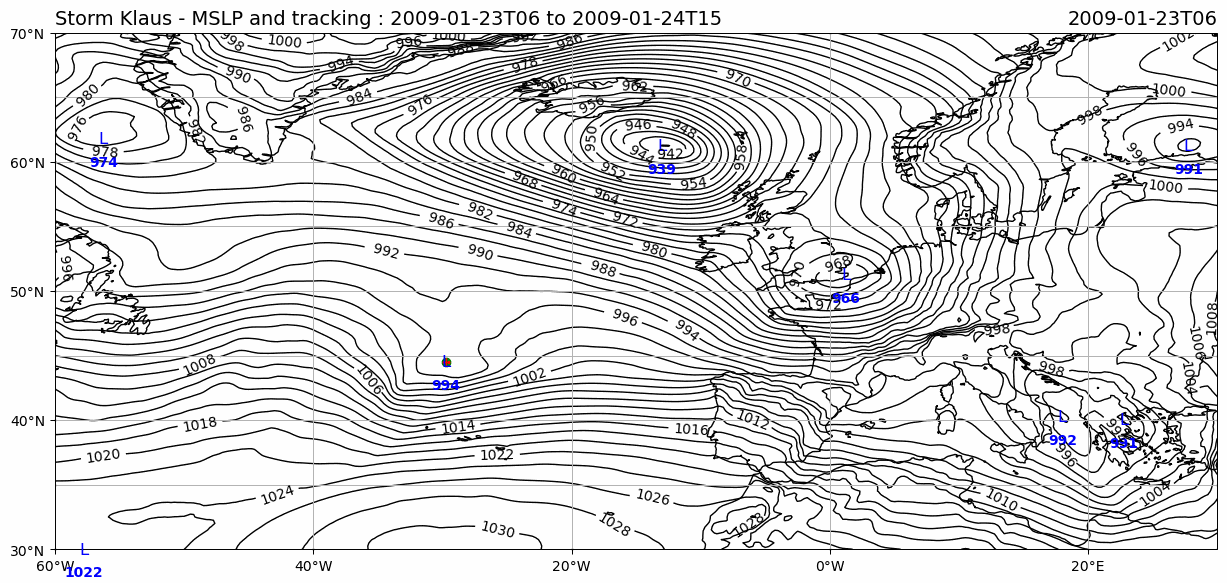

In [18]:
gif_filepath = './anim/'+storm+'/MSL_tracking.gif'
make_animation(gif_filepath)